# Exploratory Data Analysis (EDA)
## Civil Comments – Toxic Comment Classification

Objectif :
- Comprendre la structure du jeu de données Civil Comments
- Analyser la distribution des labels (toxicité)
- Étudier la longueur des commentaires
- Identifier les déséquilibres de classes

Cette analyse est réalisée **avant tout prétraitement**, afin de guider
les choix de nettoyage et de modélisation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

plt.style.use("seaborn-v0_8")


### Dataset loading

In [2]:
dataset = load_dataset("google/civil_comments")

train_ds = dataset["train"]
val_ds   = dataset["validation"]
test_ds  = dataset["test"]

df_train = train_ds.to_pandas()
df_val   = val_ds.to_pandas()
df_test  = test_ds.to_pandas()

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)


README.md: 0.00B [00:00, ?B/s]

c:\dev\toxic-ml\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alami\.cache\huggingface\hub\datasets--google--civil_comments. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


data/train-00000-of-00002.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/187M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1804874 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/97320 [00:00<?, ? examples/s]

Train shape: (1804874, 8)
Validation shape: (97320, 8)
Test shape: (97320, 8)




The **Civil Comments** dataset is loaded using the HuggingFace `datasets` library,
which directly provides predefined `train`, `validation`, and `test` splits.

Each observation corresponds to a user-generated comment, annotated along
multiple toxicity dimensions.


In [7]:
df_train.head()

,text,toxicity,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,length_chars,length_words
0,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,101,19
1,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,114,22
2,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,86,16
3,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,84,17
4,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.0,0.87234,0.021277,0.0,36,8


### Toxicity dimensions (labels)

In [3]:
label_cols = [
    "toxicity",
    "severe_toxicity",
    "obscene",
    "threat",
    "insult",
    "identity_attack"
]

label_counts = df_train[label_cols].sum().sort_values(ascending=False)

label_counts


toxicity           185933.250000
insult             146470.453125
identity_attack     40854.609375
obscene             25046.613281
threat              16805.671875
severe_toxicity      8270.111328
dtype: float32

The task addressed in this project is a **multilabel classification problem**:
a single comment can belong to multiple toxicity categories simultaneously.

The considered labels are:
- `toxicity`: overall perceived toxicity,
- `severe_toxicity`: severe toxicity,
- `obscene`: obscene content,
- `threat`: explicit threats,
- `insult`: insulting language,
- `identity_attack`: attacks targeting a protected group.

Unlike standard binary classification, these labels are provided as
**continuous scores between 0 and 1**, representing the proportion of human
annotators who judged the comment as belonging to the corresponding category.

Therefore, summing each label column yields a **total toxicity mass** over the
training set, rather than a simple count of positive samples.


### Label distribution

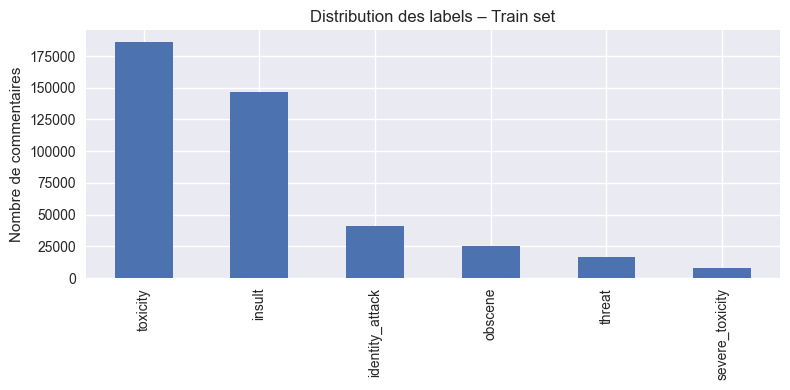

In [ ]:
label_counts.plot(kind="bar", figsize=(8,4))
plt.title("### Label distribution – Train set")
plt.ylabel("Nombre de commentaires")
plt.tight_layout()

plt.savefig("../reports/figures/label_distribution_train.png")
plt.show()


The bar plot above illustrates the distribution of toxicity dimensions within
the training set.

A **strong class imbalance** is clearly observed:
- `toxicity` and `insult` are relatively frequent,
- while `threat` and `severe_toxicity` are extremely rare.

This imbalance is a well-known characteristic of online content moderation
datasets and represents a major challenge for machine learning models.

These observations motivate:
- the use of appropriate evaluation metrics (e.g. macro F1-score),
- the possible application of class weighting strategies,
- and the choice of models robust to rare classes.


### Comment length analysis



Two complementary length measures are introduced:
- length in **characters**,
- length in **words**.

These features provide insight into the textual structure of the dataset,
revealing whether comments are predominantly short or long and whether a
long-tail distribution is present.

Understanding text length distributions is essential for:
- defining maximum sequence lengths,
- selecting suitable tokenization strategies,
- and anticipating the computational cost of downstream models.


In [8]:
df_train["length_chars"] = df_train["text"].str.len()
df_train["length_words"] = df_train["text"].str.split().apply(len)

df_train[["length_chars", "length_words"]].describe(percentiles=[0.5, 0.95])


,length_chars,length_words
count,1.804874e+06,1.804874e+06
mean,2.972343e+02,5.127690e+01
std,2.691966e+02,4.617811e+01
min,1.000000e+00,1.000000e+00
50%,2.020000e+02,3.500000e+01
95%,9.530000e+02,1.590000e+02
max,1.906000e+03,3.170000e+02


### Statistical analysis of comment lengths

The descriptive statistics indicate that:
- most comments are relatively short,
- but a long tail of very long comments exists.

This behavior is consistent with findings reported in the literature, where
median comment lengths are typically on the order of a few dozen tokens, while
extreme values can reach several hundred tokens.

These results suggest that **sequence truncation** will be necessary during
model training to control complexity while preserving informative content.


### Length histogram 

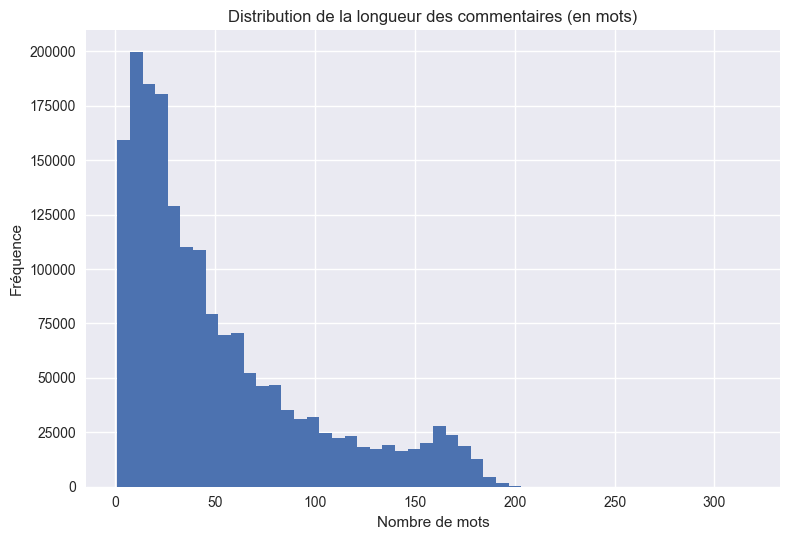

In [6]:
df_train["length_words"].hist(bins=50)
plt.title("Distribution de la longueur des commentaires (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.tight_layout()

plt.savefig("../reports/figures/comment_length_words.png")
plt.show()


### Distribution of comment lengths

The histogram highlights a highly skewed distribution:
- a strong concentration of short comments,
- followed by a gradual decay toward larger lengths.

Such distributions are typical of user-generated online content.

This observation supports:
- the use of models optimized for short texts,
- and careful preprocessing choices to avoid unnecessarily inflating sequence
  length.


### Distribution of toxicity scores

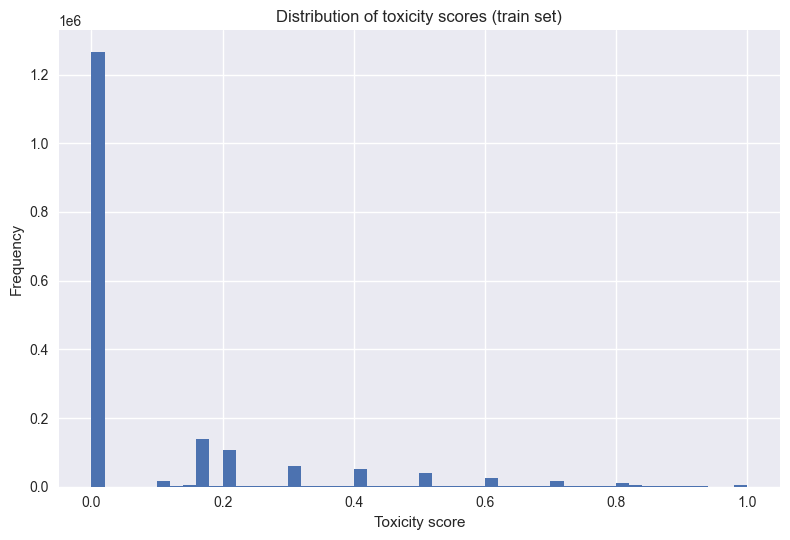

In [9]:
df_train["toxicity"].hist(bins=50)
plt.title("Distribution of toxicity scores (train set)")
plt.xlabel("Toxicity score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("../reports/figures/toxicity_score_distribution.png")
plt.show()




This histogram shows the distribution of the continuous toxicity scores in the
training set.

Most comments have toxicity scores close to zero, indicating that the dataset
is largely composed of non-toxic content. A smaller proportion of comments
exhibit higher toxicity scores, forming a long right tail.

This observation confirms the **strong imbalance** of the dataset and highlights
that toxicity is a relatively rare phenomenon. It also motivates the need to
carefully choose how continuous scores are handled, for instance through
thresholding or weighting strategies during model training.


### Proportion of toxic vs non-toxic comments

In [10]:
low_toxic = (df_train["toxicity"] < 0.1).mean()
high_toxic = (df_train["toxicity"] > 0.5).mean()

print(f"Proportion of almost non-toxic comments (toxicity < 0.1): {low_toxic:.2%}")
print(f"Proportion of highly toxic comments (toxicity > 0.5): {high_toxic:.2%}")


Proportion of almost non-toxic comments (toxicity < 0.1): 70.16%
Proportion of highly toxic comments (toxicity > 0.5): 5.90%




To further quantify class imbalance, we compute the proportion of comments with
very low toxicity scores (`toxicity < 0.1`) and highly toxic scores
(`toxicity > 0.5`).

The results show that a large majority of comments can be considered
non-toxic, while only a small fraction exhibits strong toxicity signals.

This reinforces the importance of using evaluation metrics and learning
strategies that are robust to class imbalance, especially for rare but critical
toxicity categories.


## Conclusion of the exploratory data analysis

This exploratory analysis highlights several key properties of the dataset:

- a strong **class imbalance**, especially for rare labels,
- **predominantly short comments** with a long-tail distribution,
- a **multilabel structure** with correlated toxicity dimensions.

These findings will directly inform subsequent methodological choices,
including:
- text preprocessing strategies,
- target definition and label handling,
- model selection and evaluation metrics.
